In [1]:
import pandas as pd
import struct
import os
import collections
from sklearn.preprocessing import MinMaxScaler
import pickle

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Blue = z
green = y
red = x

In [2]:
Point3D = collections.namedtuple(
    "Point3D", ["id", "xyz", "rgb", "error", "image_ids", "point2D_idxs"])


def read_next_bytes(fid, num_bytes, format_char_sequence, endian_character="<"):
    """Read and unpack the next bytes from a binary file.
    :param fid:
    :param num_bytes: Sum of combination of {2, 4, 8}, e.g. 2, 6, 16, 30, etc.
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    :param endian_character: Any of {@, =, <, >, !}
    :return: Tuple of read and unpacked values.
    """
    data = fid.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)

def read_points3D_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadPoints3DBinary(const std::string& path)
        void Reconstruction::WritePoints3DBinary(const std::string& path)
    """
    points3D = {}
    with open(path_to_model_file, "rb") as fid:
        num_points = read_next_bytes(fid, 8, "Q")[0]
        for _ in range(num_points):
            binary_point_line_properties = read_next_bytes(
                fid, num_bytes=43, format_char_sequence="QdddBBBd")
            point3D_id = binary_point_line_properties[0]
            xyz = np.array(binary_point_line_properties[1:4])
            rgb = np.array(binary_point_line_properties[4:7])
            error = np.array(binary_point_line_properties[7])
            track_length = read_next_bytes(
                fid, num_bytes=8, format_char_sequence="Q")[0]
            track_elems = read_next_bytes(
                fid, num_bytes=8*track_length,
                format_char_sequence="ii"*track_length)
            image_ids = np.array(tuple(map(int, track_elems[0::2])))
            point2D_idxs = np.array(tuple(map(int, track_elems[1::2])))
            points3D[point3D_id] = Point3D(
                id=point3D_id, xyz=xyz, rgb=rgb,
                error=error, image_ids=image_ids,
                point2D_idxs=point2D_idxs)
    return points3D

In [3]:
points = read_points3D_binary('../data/scacchiera_5_low/workspace/sparse/0/points3D.bin')
p_values = np.array(list(map(lambda x: x.xyz, points.values())))

In [4]:
positions = pd.read_csv('../data/scacchiera_5_low/positions.csv')

In [5]:
split_train = int(len(positions)/3) + 40
split_validation = (int(len(positions)/3) * 2) + 20

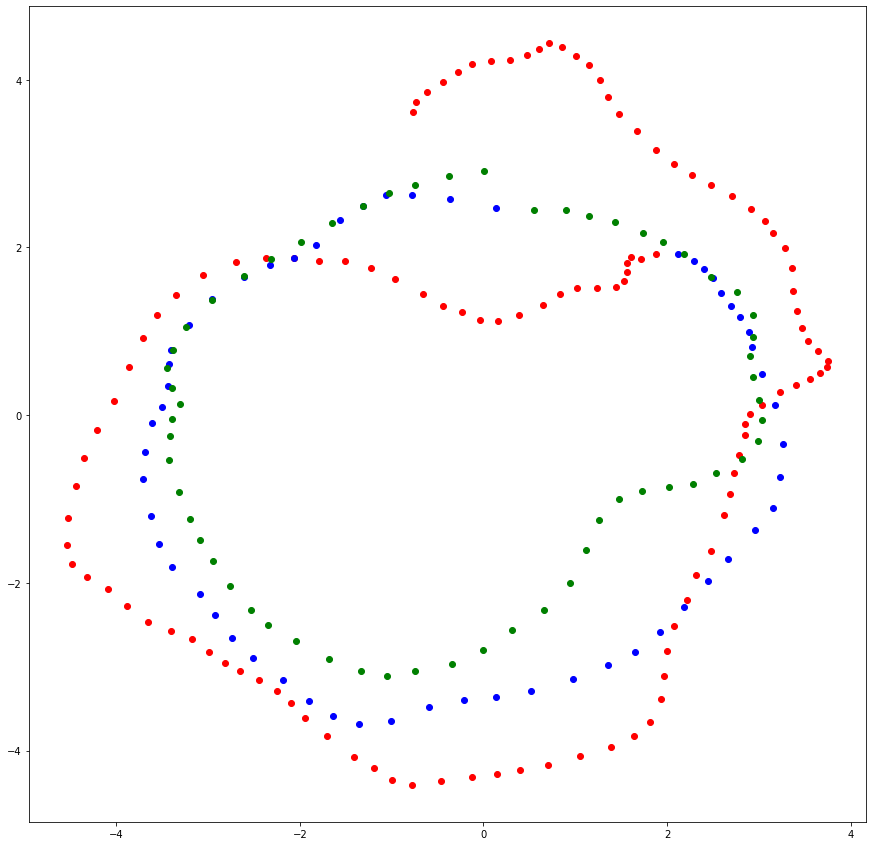

In [6]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes()
ax.scatter(positions['x'][:split_train], positions['y'][:split_train], color='red')
ax.scatter(positions['x'][split_train:split_validation], positions['y'][split_train:split_validation], color='blue')
ax.scatter(positions['x'][split_validation:], positions['y'][split_validation:], color='green')
#ax.scatter(p_values[:,0], p_values[:,1], color='black')

In [189]:
train = positions.iloc[:split_train].copy(deep=True)
val = positions.iloc[split_train:split_validation].copy(deep=True)
test = positions.iloc[split_validation:].copy(deep=True)

In [190]:
quaternion_scaler = MinMaxScaler()
quaternion_scaler = quaternion_scaler.fit(train[['qx', 'qy', 'qz', 'qw']].values.flatten().reshape(-1, 1))
translation_scaler = MinMaxScaler()
translation_scaler = translation_scaler.fit(train[['tx', 'ty', 'tz']].values.flatten().reshape(-1, 1))

for phase in [train, val, test]: 
    for col in ['qx', 'qy', 'qz', 'qw']:
        phase.update({col: quaternion_scaler.transform(phase[col].values.reshape(-1, 1)).flatten()})

    for col in ['tx', 'ty', 'tz']:
        phase.update({col: translation_scaler.transform(phase[col].values.reshape(-1, 1)).flatten()})

In [191]:
for scaler, filepath in zip([quaternion_scaler, translation_scaler], ['../data/scacchiera_5_low/quaternion_scaler.pkl', '../data/scacchiera_5_low/translation_scaler.pkl']):
    with open(filepath, 'wb') as f:
        pickle.dump(scaler, f)

In [192]:
train.to_csv("../data/scacchiera_5_low/train.csv", index=False)
val.to_csv("../data/scacchiera_5_low/validation.csv", index=False)
test.to_csv("../data/scacchiera_5_low/test.csv", index=False)

In [127]:
a = np.array([0.388426, 2.4425, 4.66])
b = np.array([-0.450115, 2.96992, 4.2277])

In [128]:
unit_measure = np.sqrt(np.sum((a - b)**2))

In [129]:
x = positions['x'] / unit_measure * 25
y = positions['y'] / unit_measure * 25
z = positions['z'] / unit_measure * 25

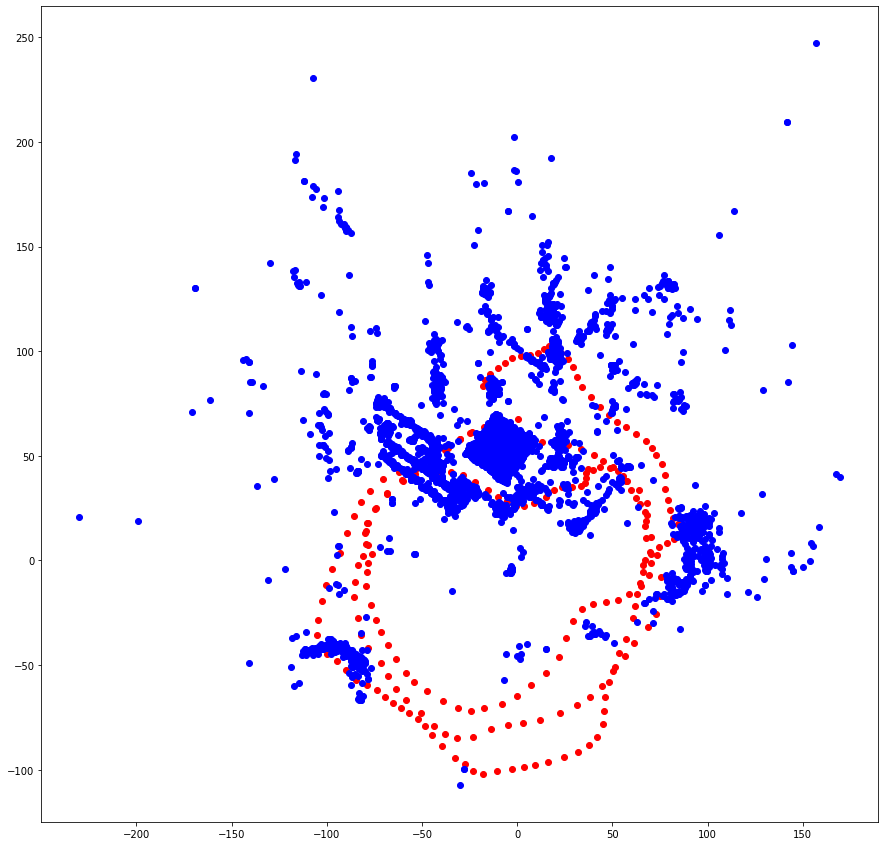

In [130]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes()
ax.scatter(x, y, color='red')
ax.scatter(p_values[:,0]/unit_measure * 25, (p_values[:,1]/unit_measure * 25),color='blue')

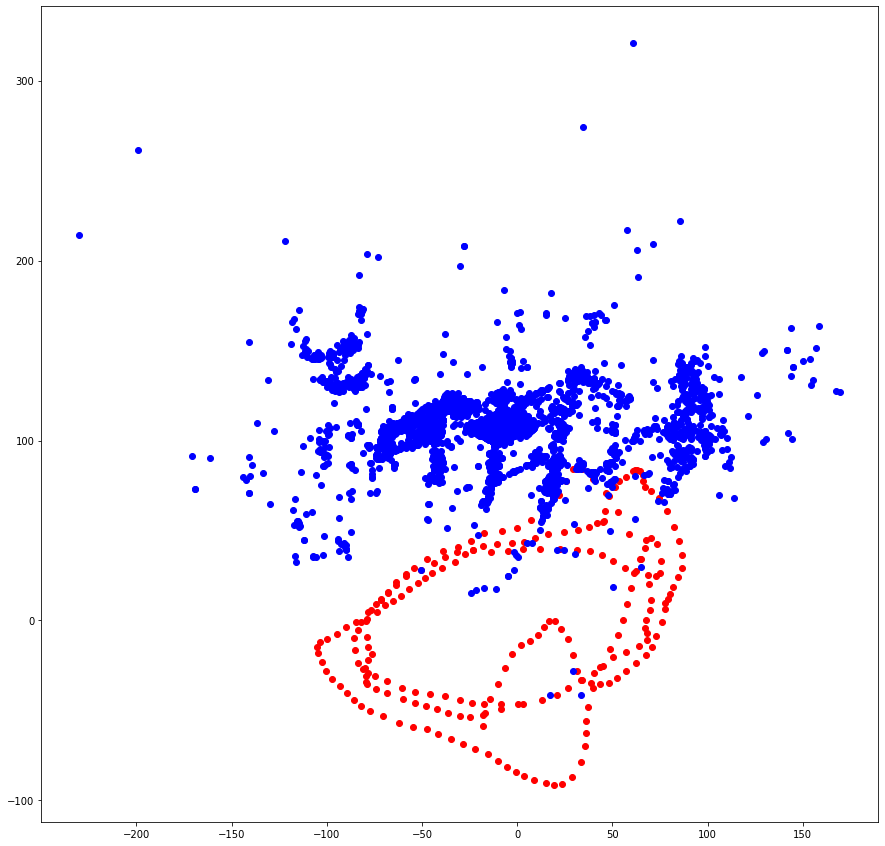

In [134]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes()
ax.scatter(x, z, color='red')
ax.scatter(p_values[:,0]/unit_measure * 25, (p_values[:,2]/unit_measure * 25),color='blue')

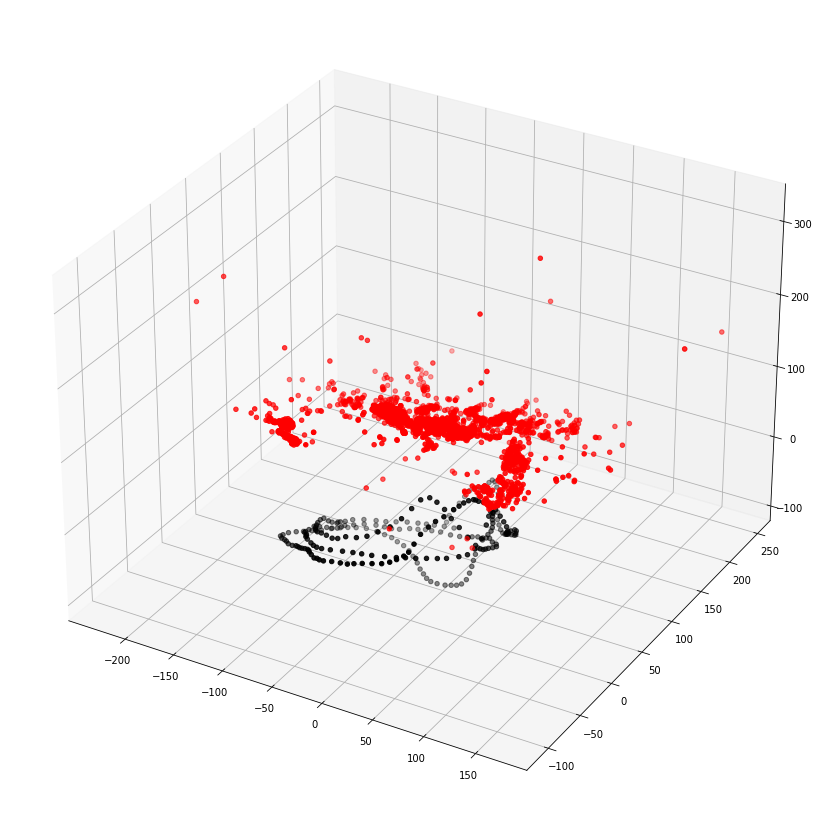

In [132]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, color='black')
ax.scatter(p_values[:,0]/unit_measure * 25, (p_values[:,1]/unit_measure * 25), (p_values[:,2]/unit_measure * 25),color='red')

In [142]:
np.min(positions['x']), np.max(positions['x']), np.min(positions['y']), np.max(positions['y']), np.min(positions['z']), np.max(positions['z']), unit_measure

(-4.535594463348389,
 3.752953290939331,
 -4.406397342681885,
 4.432503700256348,
 -3.946877479553223,
 3.647226095199585,
 1.080835859453692)

In [143]:
unit_measure

1.080835859453692